In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 10})
plt.rcParams["font.family"] = "Arial"

The maximum separation is 800.0m
CPU times: total: 3.14 s
Wall time: 2.74 s

Running inversion with SimPEG v0.23.1.dev10+gf697d2455
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.50e+00  1.83e+04  0.00e+00  1.83e+04  

C:\Users\dwill\AppData\Local\Temp\ipykernel_57004\3572630374.py:3: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


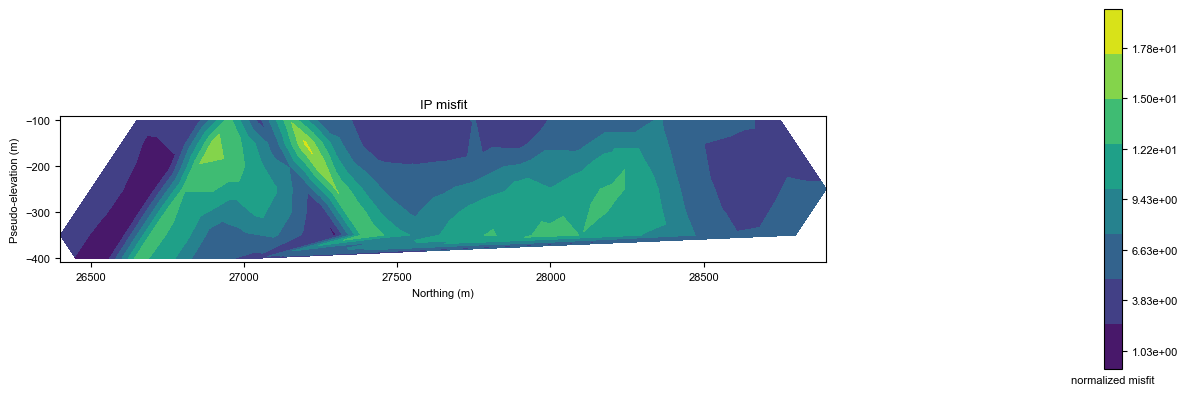

C:\Users\dwill\AppData\Local\Temp\ipykernel_57004\1237877924.py:2: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  dc_utils.plot_pseudosection(


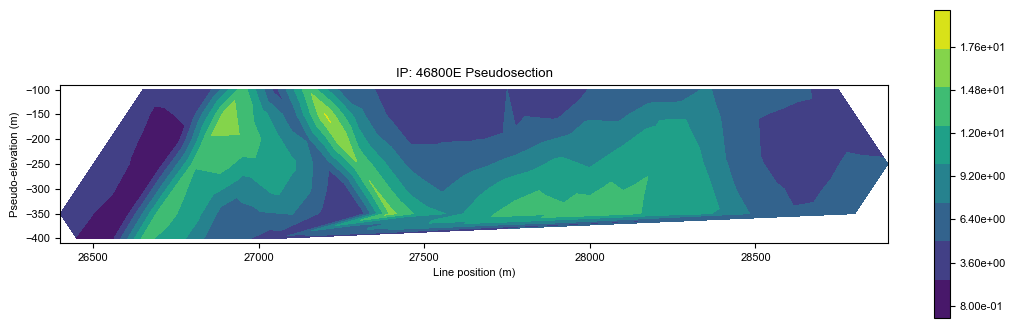

In [3]:
childnb_verbose = False
%run 1-century-dcip-inversion-S.ipynb

In [4]:
def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

# SOLA analysis
Implements the Subtractive Optimally Localized Averages
for the analysis of the IP inverse problem above.

This implementation is based on Zarolli (2016).

References

Christophe Zaroli, Global seismic tomography using Backus–Gilbert inversion, Geophysical Journal International, Volume 207, Issue 2, November 2016, Pages 876–888, https://doi.org/10.1093/gji/ggw315

In [5]:
import math
class SOLA:
    def __init__(self, dobs, dobs_err, mesh, G, ind_active=[]):
        """
        Parameters
        ----------
        dobs :
            Observed data.
        dobs_err :
            Data standard deviations.
        mesh :
            Modeling mesh.
        G :
            Sensitivity matrix.
        """

        self.G = G.copy()
        self.mesh = mesh
        self.dobs = dobs.copy()
        self.dobs_err = dobs_err.copy()
        
        self.N, self.M = np.shape(G)
        if len(ind_active) > 0:
            self.v_cells = mesh.cell_volumes[ind_active]
        else:
            self.v_cells = mesh.cell_volumes

        # Scale by the data error
        #  data
        self.dobs = np.divide(self.dobs, self.dobs_err)
        #  sensitivity matrix
        for j in range(self.M):
            self.G[:,j] = np.divide(self.G[:,j], self.dobs_err)
        
        self.G_hat = np.zeros((self.N, self.M))
        for j in range(self.M):
            self.G_hat[:, j] = self.G[:, j] / math.sqrt(self.v_cells[j])

        # create vector c_hat
        self.c_1 = np.sum(self.G[0, :])
        self.c_hat = np.zeros((self.N - 1, 1))
        for i in range(1, self.N):
            c_i = np.sum(self.G[i, :])
            self.c_hat[i-1] = c_i / self.c_1

    """
        Auxiliary functions.
    """

    def set_tradeoff_value(self, eta):
        """Set value for the resolution-error tradeoff parameter."""
        self.eta = eta

        self.I_Nminus1 = np.identity(self.N - 1)
        self.B = np.vstack((-self.c_hat.T, self.I_Nminus1))
        Ghat_tB = np.matmul(self.G_hat.T, self.B)
        self.Q_eta = np.vstack((Ghat_tB, -eta * self.c_hat.T))

    def run(self, T, avgA=False, eta_changed=True):
        """Run SOLA inversion.

        Parameters
        ----------
        r0 : list
            Coordinates of the analysis point.
        T :
            Target kernel.
        AvgA : bool
            If True, also returns the computed averaging kernel.

        """
       
        t_k = np.reshape(np.sqrt(self.v_cells) * T, (self.M, 1))

        # Set rhs y(k,eta)
        e_1 = np.zeros((self.N, 1))
        e_1[0] = 1
        f1 = t_k - (1 / self.c_1) * np.matmul(self.G_hat.T, e_1)
        f2 = -(1 / self.c_1) * self.eta
        y_k_eta = np.vstack((f1, f2))

        # Finally assemble LSQR system
        Zeros_Nminus1 = np.zeros((self.N - 1, 1))
        if eta_changed:
            self.S = np.vstack((self.Q_eta, self.eta * self.I_Nminus1))
            self.S_inv = np.linalg.pinv(self.S)
            
        y = np.vstack((y_k_eta, Zeros_Nminus1))

        ###############################
        # Solve the SOLA linear system
        ###############################

        #try:
        #    res = np.linalg.lstsq(self.S, y, rcond=None)
        #    x_est = res[0]
        #except:
        #    print("ERROR: lstsq did not converge!") 
        x_est = self.S_inv @ y
        
        # Last steps to complete the solution x_k
        x_hat_k = np.reshape(x_est, (self.N - 1, 1))
        x_k = np.matmul(self.B, x_hat_k) + (1 / self.c_1) * e_1

        # Compute average estimate and variance
        x_est = 0
        x_var = 0
        for i in range(self.N):
            x_est = x_est + x_k[i] * self.dobs[i]
            x_var = x_var + x_k[i]**2

        x_err = np.sqrt(x_var)

        if avgA:
            # Averaging kernel
            A_k = np.zeros((self.M, 1))
            for i in range(self.N):
                A_k[:, 0] = A_k[:, 0] + x_k[i] * self.G[i, :]

            A_k[:, 0] = np.divide(A_k[:, 0], self.v_cells)

            # Compute unimodularity constraint
            uc = 0
            for j in range(self.M):
                uc = uc + A_k[j] * self.v_cells[j]

            return x_est, x_err, A_k, uc
        else:
            return x_est, x_err


In [6]:
def disk_target_kernel(r0, radius, mesh, ind_active=[]):
    v_cells = mesh.cell_volumes
    cell_centers = mesh.cell_centers
    ncells = len(v_cells)
    T = np.zeros(ncells)

    x0 = r0[0]
    z0 = r0[1]

    # Define region around r0 with.
    xblim = np.c_[x0 - 1.5 * radius, x0 + 1.5 * radius]
    zblim = np.c_[z0 - 1.5 * radius, z0 + 1.5 * radius]
    
    # Set kernel values
    c = 0
    for i in range(ncells):
        xc = cell_centers[i, 0]
        zc = cell_centers[i, 1]
        if (np.sqrt((xc - x0) ** 2 + (zc - z0) ** 2)) <= radius:
            if len(ind_active) > 0:
                if ind_active[i]:
                    T[i] = 1
                    c = c + v_cells[i]
            else:
                T[i] = 1
                c = c + v_cells[i]

    # Normalize T
    T = T/c

    if len(ind_active) > 0:
        T_active = T[ind_active]
    else:
        T_active = T

    return T_active


In [7]:
from matplotlib.patches import Circle

def plot_Ak(Ak, r0=[], s0=[], title='', fig_name='kernel.png', interval=None):
    n = len(Ak)
    Ak_n = np.zeros(Ak[0].size)
    #for a in Ak:
    #    t = np.divide(a, np.max(abs(a)))
    #    Ak_n = Ak_n + t
    Ak_n = Ak[0]
    Ak_plot = np.divide(Ak_n, np.max(abs(Ak_n)))
    #Ak_plot = Ak[0]
    if interval is not None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    out = mesh.plot_image(Ak_plot, ax=ax, clim=(-1,1),
                          pcolor_opts={"cmap": mpl.cm.bwr},
                          grid=False)
    cb = plt.colorbar(out[0], orientation='horizontal',
                      ticks=[-1, 0, 1],
                      ax=ax, pad=-0.3)
    cb.ax.tick_params(axis='x', labelsize=12)
#    cb.ax.set_xticklabels(['-1.0', '0', '1.0'])

    plt.axis('scaled')
    
    #ax.set_title(title)
    if interval is not None:
        ax.set_xlim(interval[0], interval[1])
    else:
        ax.set_xlim(core_domain_x)
    ax.set_ylim(-400, 0)
    plt.yticks([0, -100, -200, -300, -400],['0', '-100', '-200', '-300', '-400'])
    ax.set_aspect(1)
    ax.set_xlabel('Easting (m)', loc = "center")
    ax.set_ylabel('Elevation (m)')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    #ax.xaxis.label.set_color('white')
    #ax.yaxis.label.set_color('white')

    #ax.tick_params(axis="x", colors="white")
    #ax.tick_params(axis="y", labelcolor="white")
    
    if len(s0) > 0:
        for i in range(n):
            r = r0[i]
            s = s0[i]
            circle_patch = Circle(r, s, color='k', fill=False)
            ax.add_patch(circle_patch)
            circle_patch = Circle(r, 10, color='lime', fill=True)
            ax.add_patch(circle_patch)

    plt.tight_layout()
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')

### Setup data for the inversions

In [8]:
##
# Observations
d_obs = ip_data.dobs
d_err = ip_data.standard_deviation

## Setup the sensitivity matrix 
G = simulation_ip.getJ(charge_opt).copy()
N, M = np.shape(G)
scale = np.reshape(simulation_ip._scale, (N, 1))
for i in range(N):
    G[i,:] = scale[i]*G[i,:]

v_cells = mesh.cell_volumes

## SOLA solution

In [9]:
sola_inv = SOLA(d_obs, d_err, mesh, G)

## Some experiments in particular locations

mk:  [31.45198794] ; mk_err:  [3.77682202] ; mk_err %:  [12.00821401]


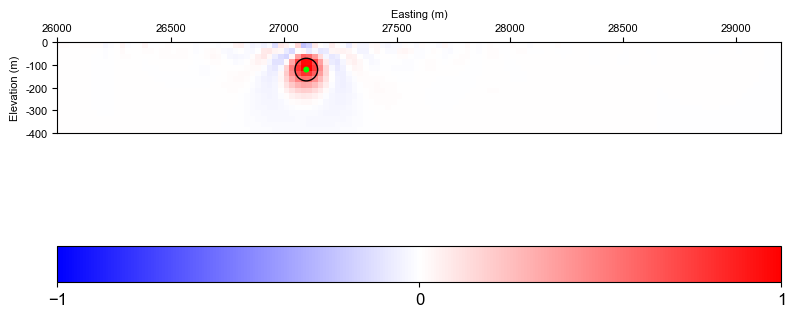

In [10]:
ncells = mesh.nC

##
# 
r0 = [27100, -120]
s = 50

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0005)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [26.81194075] ; mk_err:  [3.12929366] ; mk_err %:  [11.67126872]


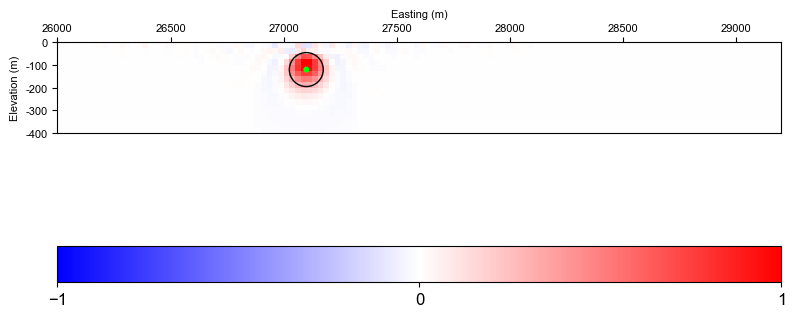

In [11]:
ncells = mesh.nC

##
# 
r0 = [27100, -120]
s = 75

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0002)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [17.0903645] ; mk_err:  [1.85664002] ; mk_err %:  [10.86366543]


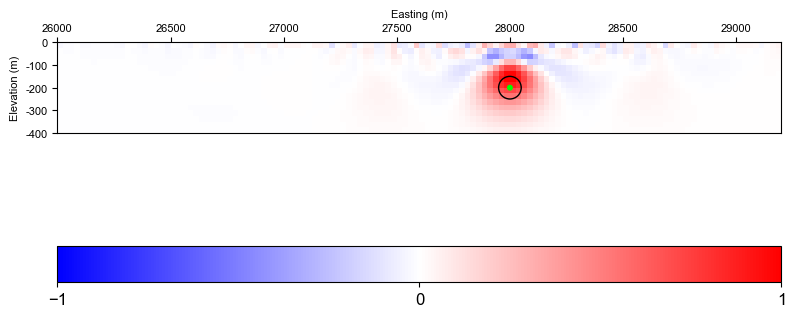

In [12]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 50

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0011)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [15.19187662] ; mk_err:  [1.52350467] ; mk_err %:  [10.02841652]


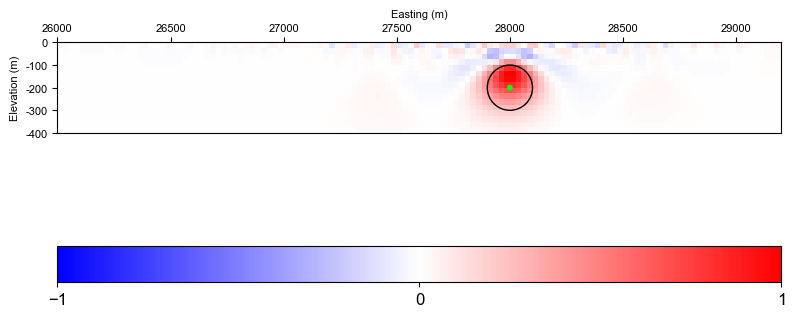

In [13]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 100

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0008)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [14.51175157] ; mk_err:  [1.47952683] ; mk_err %:  [10.19537044]


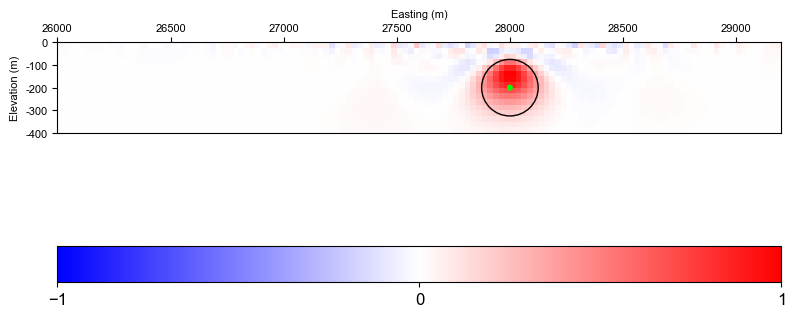

In [14]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 125

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0005)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [15.19187662] ; mk_err:  [1.52350467] ; mk_err %:  [10.02841652]


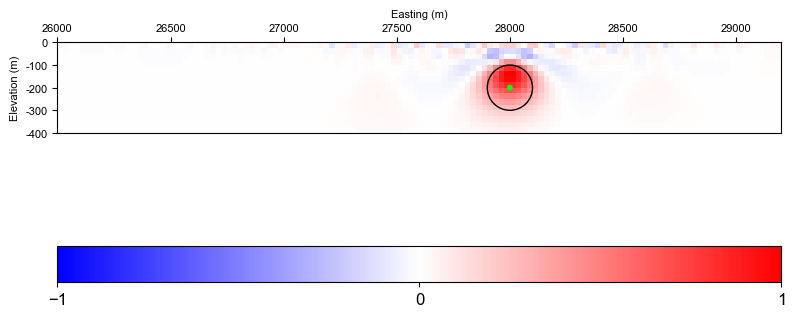

In [15]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 100

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0008)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [14.51175157] ; mk_err:  [1.47952683] ; mk_err %:  [10.19537044]


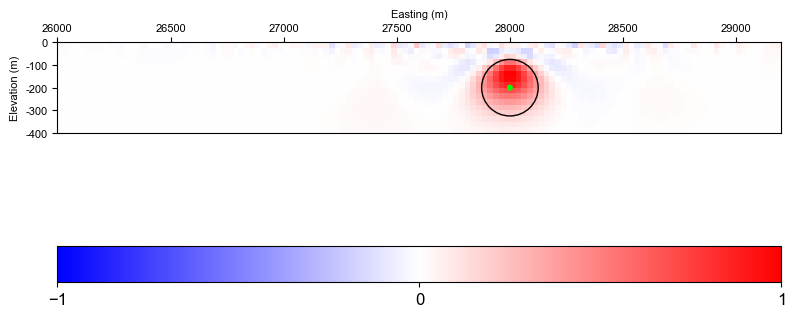

In [16]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 125

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0005)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [14.35907297] ; mk_err:  [1.48505328] ; mk_err %:  [10.3422643]


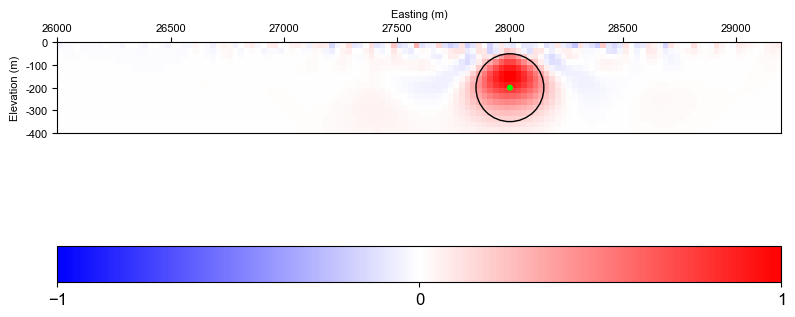

In [17]:
ncells = mesh.nC

##
# 
r0 = [28000, -200]
s = 150

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.0004)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s])

mk:  [7.37561074] ; mk_err:  [0.38263955] ; mk_err %:  [5.18790332]


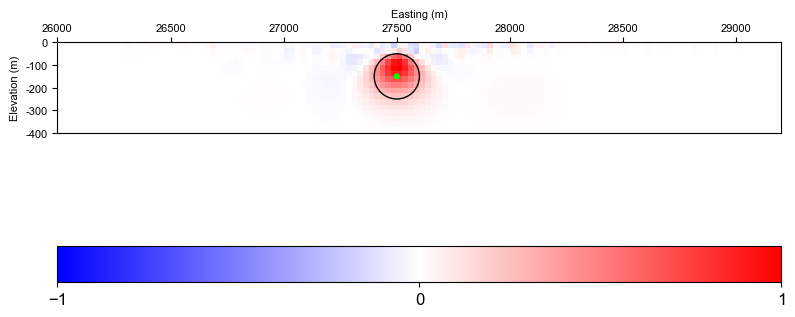

In [18]:
ncells = mesh.nC

##
# 
r0 = [27500, -150]
s = 100

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.003)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s], 'SOLA averaging kernel')


mk:  [5.22853775] ; mk_err:  [0.42793816] ; mk_err %:  [8.18466243]


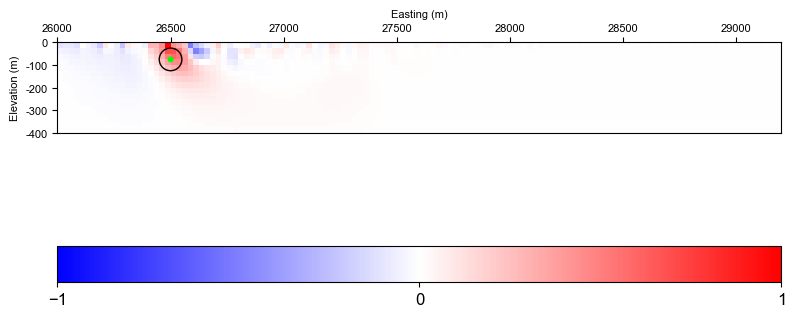

In [19]:
ncells = mesh.nC

##
# 
r0 = [26500, -75]
s = 50

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.005)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s], 'SOLA averaging kernel')

mk:  [7.54767704] ; mk_err:  [0.39812792] ; mk_err %:  [5.2748404]


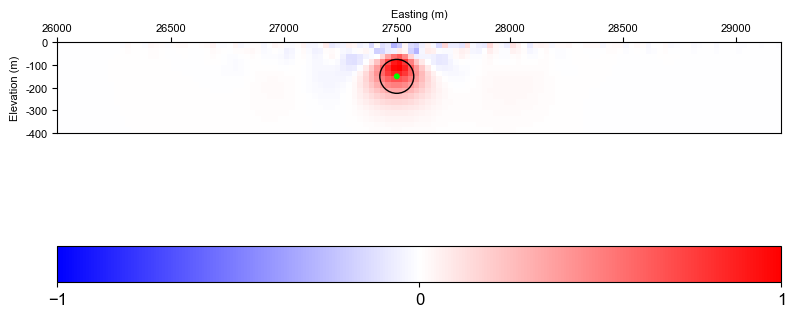

In [20]:
ncells = mesh.nC

##
# 
r0 = [27500, -150]
s = 75

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.005)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s], 'SOLA averaging kernel')

mk:  [8.98227639] ; mk_err:  [0.45698466] ; mk_err %:  [5.08762629]


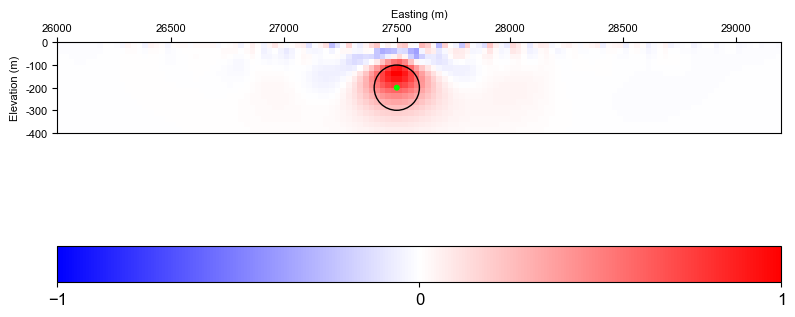

In [21]:
ncells = mesh.nC

##
# 
r0 = [27500, -200]
s = 100

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.003)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s], 'SOLA averaging kernel')

mk:  [10.34787393] ; mk_err:  [0.46254985] ; mk_err %:  [4.46999886]


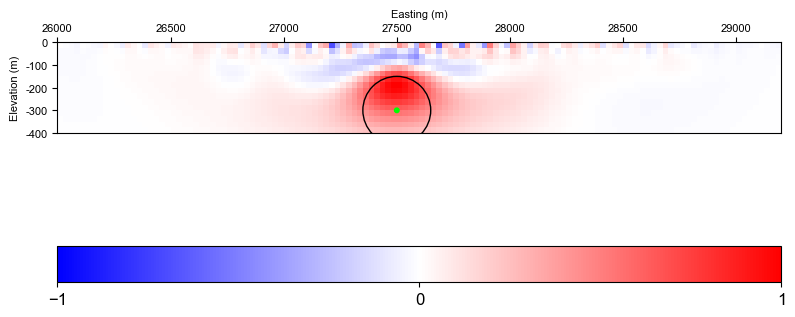

In [22]:
ncells = mesh.nC

##
# 
r0 = [27500, -300]
s = 150

T = disk_target_kernel(r0, s, mesh)
sola_inv.set_tradeoff_value(0.002)
mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)

print("mk: ", mk, "; mk_err: ", mk_err, "; mk_err %: ", (mk_err/mk)*100)
plot_Ak([Ak[:,0]], [r0], [s], 'SOLA averaging kernel')

## Inversion in the entire domain

### Plot of sensitivity matrix

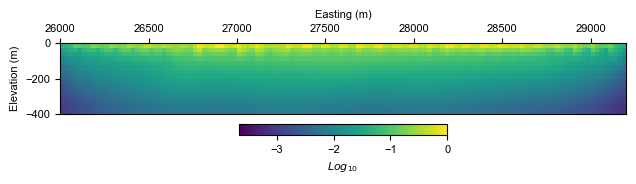

In [23]:
# Normalized sensitivity
den = np.max(np.sum(abs(G), 0))
D = np.sum(abs(G), 0)/den
D = np.log10(D)

D_plot = np.zeros(len(mesh))
D_plot = D
    
fig, ax = plt.subplots(1, 1)
out = mesh.plot_image(D_plot, ax=ax,
                      pcolor_opts={"cmap": mpl.colormaps['viridis']},
                      grid=False)
cb = plt.colorbar(out[0], fraction=0.025,
                  orientation='horizontal',
                  #ticks=[-1, 0, 1],
                  ax=ax, pad=0.025)
cb.ax.set_xlabel('$Log_{10}$')    
#cb.ax.set_xticklabels(['-1.0', '0', '1.0'])

ax.set_xlim(core_domain_x)
ax.set_ylim(-400, 0)
ax.set_aspect(2)  # some vertical exxageration
ax.set_xlabel('Easting (m)', loc = "center")
ax.set_ylabel('Elevation (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_aspect(1)
plt.tight_layout()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


## Inversion for the entire domain

In [25]:
##
# Find total number of cells in the region of interest
cell_centers = mesh.cell_centers
nC = mesh.nC

xmin = core_domain_x[0]; xmax = core_domain_x[1]
zmin = -400; zmax = 0

nc_total = 0
for i in range(nC):
    xc = cell_centers[i,0]
    zc = cell_centers[i,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            nc_total = nc_total + 1


2048


In [26]:
%%time

##
# Inversion for the entire domain
Dsorted_ind = np.argsort(D)

cell_centers = mesh.cell_centers
nC = mesh.nC
mk = np.zeros(nC)
merr = np.zeros(nC)
s = np.zeros((nC,3))
eta_inv = np.zeros(nC)

rmin = 40
rmax = 150
eta_min = 0.0005
eta_max = 0.005 
k1 = mesh.closest_points_index([27500, -50], 'cell_centers')
k2 = mesh.closest_points_index([27500, -350], 'cell_centers')
k1 = k1[0]
k2 = k2[0]

D1 = D[k1]
D2 = D[k2]
rho_min = D[k2]
rho_max = D[k1]

xmin = core_domain_x[0]; xmax = core_domain_x[1]
zmin = -400; zmax = 0

eta = 0.
nc_proc = 0
for i in range(nC):
    k = Dsorted_ind[i] 
    xc = cell_centers[k,0]
    zc = cell_centers[k,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            r0 = np.r_[xc, zc]
            #k = mesh.closest_points_index(r0, 'cell_centers')
            s[k,0] = xc; s[k,1] = zc
            # Set target kernel size            
            rho = D[k]
            if rho > rho_max:
                rho = rho_max
            if rho < rho_min:
                rho = rho_min
            s[k,2] = rmax - (rmax - rmin)*((rho - rho_min)/(rho_max - rho_min)) 
            T = disk_target_kernel(r0, s[k,2], mesh)
            eta_t = eta_max - (eta_max - eta_min)*(1 - (rho - rho_min)/(rho_max - rho_min))      
            eta_f = False
            if eta > 0:
                eta_diff = abs(eta_t-eta)/eta
            else:
                eta_diff = 1.
            
            if eta_diff > 0.1:
                eta = eta_t
                sola_inv.set_tradeoff_value(eta)
                eta_f = True
                
            eta_inv[k] = eta
            nc_proc = nc_proc + 1
            nc_perc = nc_proc/nc_total * 100
            
            print(f"cell being processed: {nc_proc}/{nc_total} [{nc_perc:.2f}%] p:[{xc:.2f},{zc:.2f}] [{eta:.2f}]", end='\r')
            
            mk[k], merr[k] = sola_inv.run(T, avgA=False, eta_changed=eta_f)  


cell being processed: 1/2048 [0.05%] p:[29187.50,-362.50] [0.00]

<timed exec>:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


CPU times: total: 5min 15s/2048 [100.00%] p:[26912.50,-12.50] [0.00]
Wall time: 2min 47s


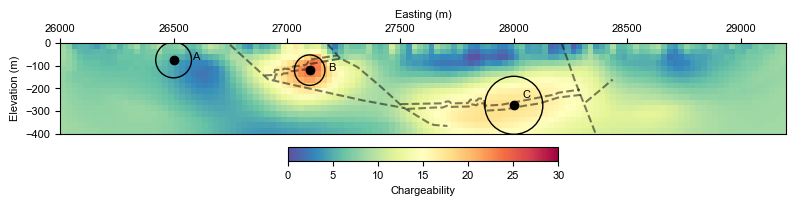

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
eta = mk

smin = 0
smax = np.max(eta)
out = mesh.plot_image(eta, normal="Y",
                      ax=ax, clim=(0,30),
                      grid=False, pcolor_opts={'cmap': 'Spectral_r'})

geologic_section = load_leapfrog_geologic_section()
for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)

cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Chargeability")

ax.set_xlim(core_domain_x)
ax.set_ylim(-400, 0)
ax.set_xlabel('Easting (m)', loc = "center")
ax.set_ylabel('Elevation (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_aspect(1)
plt.tight_layout()

# Plot target analysis points
plt.scatter(26500, -75, c='k')
k = mesh.closest_points_index([26500, -75], 'cell_centers')
circle_patch = Circle([26500, -75], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(27100, -120, c='k')
k = mesh.closest_points_index([27100, -120], 'cell_centers')
circle_patch = Circle([27100, -120], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(28000, -275, c='k')
k = mesh.closest_points_index([28000, -275], 'cell_centers')
circle_patch = Circle([28000, -275], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.text(27180, -120, 'B')
plt.text(28040, -240, 'C')
plt.text(26580, -75, 'A')
           
plt.savefig('sola_sol.png', dpi=300, bbox_inches='tight')

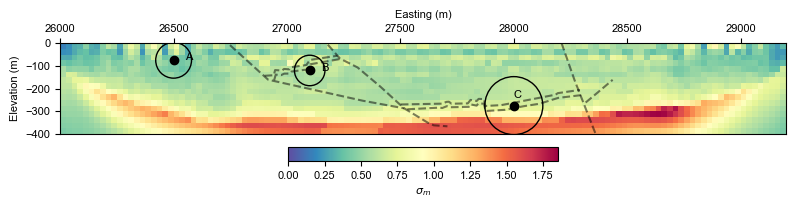

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
eta = merr
out = mesh.plot_image(eta, normal="Y",
                      ax=ax,
                      grid=False, pcolor_opts={'cmap': 'Spectral_r'})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label(r"$\sigma_m$")

geologic_section = load_leapfrog_geologic_section()
for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
    
ax.set_xlim(core_domain_x)
ax.set_ylim(-400, 0)
ax.set_aspect(2)  # some vertical exxageration
ax.set_xlabel('Easting (m)', loc = "center")
ax.set_ylabel('Elevation (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Plot target analysis points
plt.scatter(26500, -75, c='k')
k = mesh.closest_points_index([26500, -75], 'cell_centers')
circle_patch = Circle([26500, -75], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(27100, -120, c='k')
k = mesh.closest_points_index([27100, -120], 'cell_centers')
circle_patch = Circle([27100, -120], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(28000, -275, c='k')
k = mesh.closest_points_index([28000, -275], 'cell_centers')
circle_patch = Circle([28000, -275], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.text(27150, -120, 'B')
plt.text(28000, -240, 'C')
plt.text(26550, -75, 'A')

ax.set_aspect(1)
plt.tight_layout()

plt.savefig('sola_err.png', dpi=300, bbox_inches='tight')

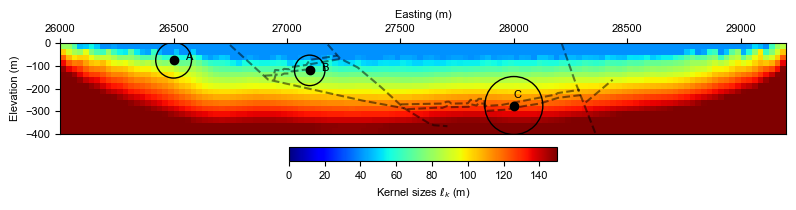

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#eta = np.divide(merr, abs(mk))*100
#eta[np.where(eta>100)] = np.NaN
sv = s[:,2]
out = mesh.plot_image(sv, normal="Y",
                      ax=ax,
                      grid=False, pcolor_opts={'cmap': 'jet'})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label(r"Kernel sizes $\ell_k$ (m)")

geologic_section = load_leapfrog_geologic_section()
for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
    
ax.set_xlim(core_domain_x)
ax.set_ylim(-400, 0)
ax.set_aspect(2)  # some vertical exxageration
ax.set_xlabel('Easting (m)', loc = "center")
ax.set_ylabel('Elevation (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Plot target analysis points
plt.scatter(26500, -75, c='k')
k = mesh.closest_points_index([26500, -75], 'cell_centers')
circle_patch = Circle([26500, -75], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(27100, -120, c='k')
k = mesh.closest_points_index([27100, -120], 'cell_centers')
circle_patch = Circle([27100, -120], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)

plt.scatter(28000, -275, c='k')
k = mesh.closest_points_index([28000, -275], 'cell_centers')
circle_patch = Circle([28000, -275], s[k,2], color='k', fill=False)
ax.add_patch(circle_patch)
plt.text(27150, -120, 'B')
plt.text(28000, -240, 'C')
plt.text(26550, -75, 'A')

ax.set_aspect(1)
plt.tight_layout()

plt.savefig('sola_kernel_sizes.png', dpi=300, bbox_inches='tight')

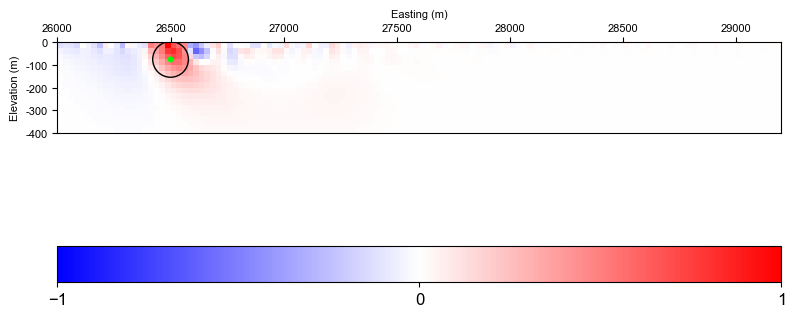

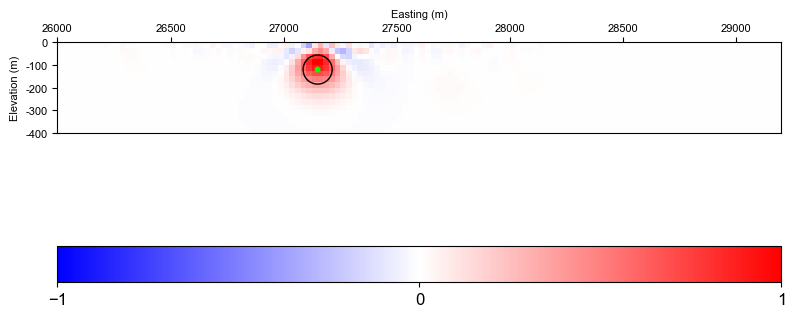

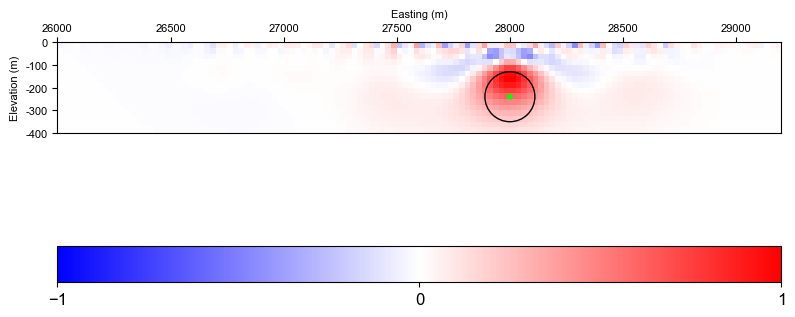

In [30]:
##
# 
r0_A = [26500, -75]
k = mesh.closest_points_index(r0_A, 'cell_centers')
s_A = s[k,2]
T = disk_target_kernel(r0_A, s_A, mesh)
sola_inv.set_tradeoff_value(eta_inv[k])
mk_A, mk_err_A, Ak_A, uc = sola_inv.run(T, avgA=True)

r0_B = [27150, -120]
k = mesh.closest_points_index(r0_B, 'cell_centers')
s_B = s[k,2]
T = disk_target_kernel(r0_B, s_B, mesh)
sola_inv.set_tradeoff_value(eta_inv[k])
mk_B, mk_err_B, Ak_B, uc = sola_inv.run(T, avgA=True)

r0_C = [28000, -240]
k = mesh.closest_points_index(r0_C, 'cell_centers')
s_C = s[k,2]
T = disk_target_kernel(r0_C, s_C, mesh)
sola_inv.set_tradeoff_value(eta_inv[k])
mk_C, mk_err_C, Ak_C, uc = sola_inv.run(T, avgA=True)

#L = [28000, -240]
#ax = plot_Ak([Ak_A[:,0], Ak_B[:,0], Ak_C[:,0]], [r0_A, r0_B, r0_C], [s_A, s_B, s_C])
#print(s_C)
plot_Ak([Ak_A[:,0]], [r0_A], [s_A], title='', fig_name='kernel_A')
plot_Ak([Ak_B[:,0]], [r0_B], [s_B], title='', fig_name='kernel_B')
plot_Ak([Ak_C[:,0]], [r0_C], [s_C], title='', fig_name='kernel_C')
